In [5]:
from binance.client import Client
import pandas as pd

import numpy as np
from datetime import datetime
import warnings

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
public_key = 'e1d7cb244abecac6d9a32032de40c50d0ebab221879e8d0e827a2ef80a67f307'
secrect_key = 'f55b0a5da751c351845f062f253e23491bbefd6a00016036d5b36842faebcad6'
currency = 'BTCUSDT'
vela = "1m"

client = Client(public_key, secrect_key)

filter = " 6 hours ago UTC"

if vela == "1m":
    klines = client.get_historical_klines(currency, Client.KLINE_INTERVAL_1MINUTE, filter)


string_headers = 'Open time	Open	High	Low	Close	Volume	Close time	Base asset volume	Number of trades	Taker buy volume	Taker buy base asset volume	Ignore'
headers = string_headers.split('\t')
df = pd.DataFrame(klines, columns=headers)

df['date'] = pd.to_datetime(df['Close time'], unit='ms', origin='unix')
df = df.rename(columns = {'Open': 'open',  'High': 'high', 'Low': 'low', 'Close': 'close', 'Close time': 'timestamp'})
df['open'] = df['open'].astype('float')
df['high'] = df['high'].astype('float')
df['low'] = df['low'].astype('float')
df['close'] = df['close'].astype('float')

df = df[['date', 'open', 'high', 'low', 'close', 'timestamp']]

In [57]:
dic_result = []
variable_a_medir = 'close'

regressor = LinearRegression()

longitud = df.shape[0]
for longi in range(longitud, 1, -longitud//30):
    local_Xset = df.iloc[longi:]
    #print(f'longi: {longi}, shape: {local_Xset.shape[0]}')
    if local_Xset.shape[0] > 30:
        X = local_Xset['timestamp'].values.reshape(-1,1)
        Y = local_Xset[variable_a_medir].values.reshape(-1,1)

        regressor.fit(X, Y) #training the algorithm
        Y_est = regressor.predict(X)

        dic_result.append({'coeficiente': list(list(regressor.coef_)[0])[0], 'MAE': metrics.mean_absolute_error(Y, Y_est),
                        'MSErr':metrics.mean_squared_error(Y, Y_est), 'num_obs': local_Xset.shape[0]})

regres_result = pd.DataFrame.from_dict(dic_result)

In [59]:
#define F-test function
# rechazar Ho si p < 0.05
def f_test(row):
    # F debe ser mayor o igual a 1 por tanto:
    f = row['F']  if row['F'] >= 1 else 1/row['F']
    n1 = row['n1'] - 2 if f >= 1 else row['n2'] - 2
    n2 = row['n2'] - 2 if f >= 1 else row['n1'] - 2
    p = 1-scipy.stats.f.cdf(f, n1, n2) #find p-value of F test statistic 
    return p

def t_test(row):
    pass



regres_result['F'] = regres_result.MSErr / regres_result.MSErr.shift()
regres_result['n1'] = regres_result.num_obs.astype('float')
regres_result['n2'] = regres_result.num_obs.shift()
regres_result = regres_result.dropna()
regres_result['p'] = regres_result.apply(lambda row: f_test(row), axis=1)

regres_result

,coeficiente,MAE,MSErr,num_obs,F,n1,n2,p,p1
1,-0.000204,119.715162,23392.405970,48,1.066853,48.0,36.0,0.425477,0.424236
2,-0.000178,115.799358,21592.616203,60,0.923061,60.0,48.0,0.390796,0.618500
3,-0.000128,130.812160,23892.451098,72,1.106510,72.0,60.0,0.345945,0.344708
4,-0.000114,120.754894,21572.019859,84,0.902880,84.0,72.0,0.330403,0.675336
5,-0.000113,108.255776,18961.144012,96,0.878969,96.0,84.0,0.274400,0.730469
6,-0.000118,108.600995,18558.517247,108,0.978766,108.0,96.0,0.458816,0.544528
7,-0.000106,106.944015,18568.458611,120,1.000536,120.0,108.0,0.500201,0.500178
8,-0.000094,111.402041,19201.512631,132,1.034093,132.0,120.0,0.427048,0.426739
9,-0.000085,113.640411,19625.197416,144,1.022065,144.0,132.0,0.450320,0.450124
10,-0.000081,109.210385,18687.967962,156,0.952244,156.0,144.0,0.383767,0.618364


In [44]:
# arg_sup_ind = regres_result.loc[regres_result.p < 0.1].index[0]-1
# regres_result.loc[arg_sup_ind]['num_obs']
regres_result

# a ṕartir de los ultimos 60 valores (close) del dataset, se genera una lista
# esa lista se le van agregando valores en tiempo real y con todos los datos se calcula otra
# regresion, con MSE y F para calcular los MSE de originales con los de nuevos datos

,coeficiente,MAE,MSErr,num_obs
0,-0.000098,118.664875,21926.542329,36
1,-0.000204,119.715162,23392.405970,48
2,-0.000178,115.799358,21592.616203,60
3,-0.000128,130.812160,23892.451098,72
4,-0.000114,120.754894,21572.019859,84
5,-0.000113,108.255776,18961.144012,96
6,-0.000118,108.600995,18558.517247,108
7,-0.000106,106.944015,18568.458611,120
8,-0.000094,111.402041,19201.512631,132
9,-0.000085,113.640411,19625.197416,144


In [55]:
arg_sup_ind

2

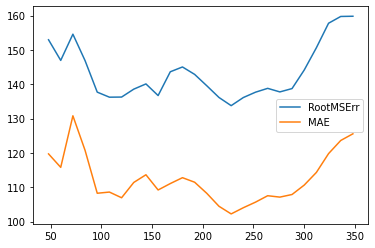

In [9]:
x = regres_result.num_obs
y = regres_result.RootMSErr
z = regres_result.MAE

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x, y)
plt.plot(x, z)
ax.legend(('RootMSErr', 'MAE'))


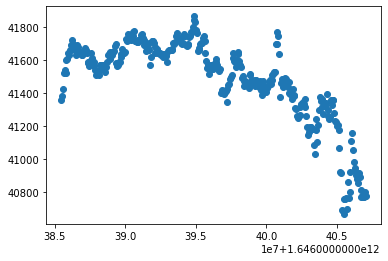

In [10]:
x = df.timestamp.values
y = df.close.values

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x, y)


In [12]:
regressor = LinearRegression()
X = df.timestamp.values.reshape(-1,1)
Y = df.close.values.reshape(-1,1)

regressor.fit(X, Y) #training the algorithm
Y_est = regressor.predict(X)

In [19]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator
    print(f'f: {f}')
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
x = [18, 19, 22, 25, 27, 28, 41, 45, 51, 55]
y = [14, 15, 15, 17, 18, 22, 25, 25, 27, 34]
f_test(x, y)



10